In [1]:
tempest_fileout='/home/b/b382216/scratch/test/tmpdir_tco2559-ng5-cycle3/tempest_output_20200120T18.txt'
with open(tempest_fileout) as f:
    lines = f.readlines()
first = lines[0].split('\t')
date = first[0] + first[1].zfill(2) + first[2].zfill(2) + first[4].rstrip().zfill(2)
lon_lat = [line.split('\t')[3:] for line in lines[1:]]
tempest_nodes = {'date': date, 
                        'lon': [val[0] for val in lon_lat],
                        'lat': [val[1] for val in lon_lat]}

tempest_nodes

{'date': '2020012006',
 'lon': ['324.000000',
  '296.000000',
  '338.000000',
  '247.000000',
  '201.000000',
  '74.000000',
  '31.000000'],
 'lat': ['-70.500000',
  '-69.500000',
  '-58.500000',
  '-57.500000',
  '-38.500000',
  '66.500000',
  '78.500000']}

In [1]:
import pandas as pd
import numpy as np
import copy
import sys
sys.path.insert(0, '../') # Hack to import from parent directory, to be removed
from tropical_cyclones import TCs
from aqua.util import load_yaml
from aqua.logger import log_configure
mainlogger = log_configure('INFO', log_name='MAIN')

FDB5 binary library not present on system, disabling FDB support.


To run notebook with slurm

In [2]:
from aqua.slurm import slurm
slurm.job(cores=8, memory="50 GB", jobs=1, queue = "interactive", walltime='6:00:00')

2023-07-03 22:02:16 :: create_folder :: WARNING  -> Folder ./slurm already exists
2023-07-03 22:02:16 :: create_folder :: WARNING  -> Folder ./slurm/logs already exists
2023-07-03 22:02:16 :: create_folder :: WARNING  -> Folder ./slurm/output already exists
2023-07-03 22:02:20 :: slurm :: WARNING  -> #!/usr/bin/env bash

#SBATCH -J dask-worker
#SBATCH -p interactive
#SBATCH -A bb1153
#SBATCH -n 1
#SBATCH --cpus-per-task=8
#SBATCH --mem=47G
#SBATCH -t 6:00:00
#SBATCH --error=./slurm/logs/dask-worker-%j.err
#SBATCH --output=./slurm/output/dask-worker-%j.out

/work/bb1153/b382216/mambaforge/envs/TCs/bin/python -m distributed.cli.dask_worker tcp://136.172.124.6:38227 --nthreads 2 --nworkers 4 --memory-limit 11.64GiB --name dummy-name --nanny --death-timeout 60



Info on slurm job

In [3]:
slurm.squeue()

JOBID      CPUS  NODES ST         NAME                 TIME       START_TIME           DEPENDENCY           PARTITION            MIN_MEMORY          
5847323    24    1     R          dask-worker          0:10       2023-07-03T22:02:21  (null)               interactive          47G                 


0

Streaming of chunks of data implemented on DetectNodes, then run StitchNodes every period of n_days

In [2]:
# load the config file
tdict = load_yaml('../config/config_levante.yml')
tdict

{'dataset': {'model': 'IFS', 'exp': 'tco2559-ng5-cycle3', 'source2d': '2D_1h_native', 'source3d': '3D_1h6h_native'}, 'paths': {'regdir': '/scratch/b/b382216/regrid_tco2559-ng5-cycle3', 'tmpdir': '/scratch/b/b382216/tmpdir_tco2559-ng5-cycle3', 'fulldir': '/scratch/b/b382216/fullres_tco2559-ng5-cycle3', 'plotdir': '/home/b/b382216/AQUA/AQUA/diagnostics/tropical_cyclones/plot'}, 'grids': {'lowgrid': 'r100', 'highgrid': 'r010'}, 'varlist': ['msl', '10u', '10v', 'tprate'], 'time': {'startdate': '2020-01-20', 'enddate': '2024-12-31', 'frequency': '6h'}, 'stream': {'streamstep': 10}, 'detect': {'boxdim': 10}, 'stitch': {'n_days_freq': 30, 'n_days_ext': 2}}

In [5]:
# initialise tropical class with streaming options
tropical = TCs(tdict=tdict, streaming=True, stream_step=tdict['stream']['streamstep'], stream_unit="days", 
               stream_startdate=tdict['time']['startdate'], loglevel = "WARNING")
tropical.loop_streaming(tdict)

2023-07-03 22:02:42 :: TCs :: WARNING  -> Initialised streaming for 10 days starting on 2020-04-09
2023-07-03 22:03:06 :: TCs :: WARNING  -> processing time step 20200409T00
2023-07-03 22:04:03 :: TCs :: WARNING  -> processing time step 20200409T06


KeyboardInterrupt: 

In [3]:
# initialise tropical class with streaming options
tropical = TCs(tdict=tdict, streaming=True, stream_step=tdict['stream']['streamstep'], stream_unit="days", 
               stream_startdate=tdict['time']['startdate'], loglevel = "WARNING")

# retrieve the data and call detect nodes on the first chunk of data
tropical.data_retrieve()
tropical.detect_nodes_zoomin()

# parameters for stitch nodes (to save tracks of selected variables in netcdf)
n_days_stitch = tdict['stitch']['n_days_freq'] + tdict['stitch']['n_days_ext']
last_run_stitch = pd.Timestamp(tropical.startdate)

# loop to simulate streaming
while len(np.unique(tropical.data2d.time.dt.day)) == tdict['stream']['streamstep']:
    tropical.data_retrieve()
    mainlogger.warning(f"New streaming from {pd.Timestamp(tropical.stream_startdate).strftime('%Y%m%dT%H')} to {pd.Timestamp(tropical.stream_enddate).strftime('%Y%m%dT%H')}")
    timecheck = (tropical.data2d.time.values > np.datetime64(tdict['time']['enddate']))
    
    if timecheck.any():
        tropical.stream_enddate = tropical.data2d.time.values[np.where(timecheck)[0][0]-1] 
        mainlogger.warning(f'Modifying the last stream date {tropical.stream_enddate}') 

    # call to Tempest DetectNodes
    tropical.detect_nodes_zoomin()

    if timecheck.any():
        break
    
    # add one hour since time ends at 23
    dayspassed = (tropical.stream_enddate + np.timedelta64(1, 'h')- last_run_stitch) / np.timedelta64(1, 'D')

    # call Tempest StitchNodes every n_days_freq days time period and save TCs tracks in a netcdf file
    if (dayspassed >= n_days_stitch):
        end_run_stitch = last_run_stitch + np.timedelta64(tdict['stitch']['n_days_freq'], 'D')
        mainlogger.warning(f'Running stitch nodes from {last_run_stitch} to {end_run_stitch}')
        tropical.stitch_nodes_zoomin(startdate=last_run_stitch, enddate=end_run_stitch,
            n_days_freq=tdict['stitch']['n_days_freq'], n_days_ext=tdict['stitch']['n_days_ext'])
        last_run_stitch = copy.deepcopy(end_run_stitch)

# end of the loop for the last chunk of data
end_run_stitch = np.datetime64(tdict['time']['enddate'])
mainlogger.warning(f'Running stitch nodes from {last_run_stitch} to {end_run_stitch}')
tropical.stitch_nodes_zoomin(startdate=pd.Timestamp(last_run_stitch), enddate=pd.Timestamp(end_run_stitch),
            n_days_freq=tdict['stitch']['n_days_freq'], n_days_ext=tdict['stitch']['n_days_ext'])
        


2023-07-04 12:28:09 :: TCs :: WARNING  -> Initialised streaming for 10 days starting on 2020-01-20
2023-07-04 12:28:38 :: TCs :: WARNING  -> processing time step 20200120T00
2023-07-04 12:29:22 :: TCs :: WARNING  -> processing time step 20200120T06


KeyboardInterrupt: 

Plot pressure, u, v and precipitation following a track for a few time steps

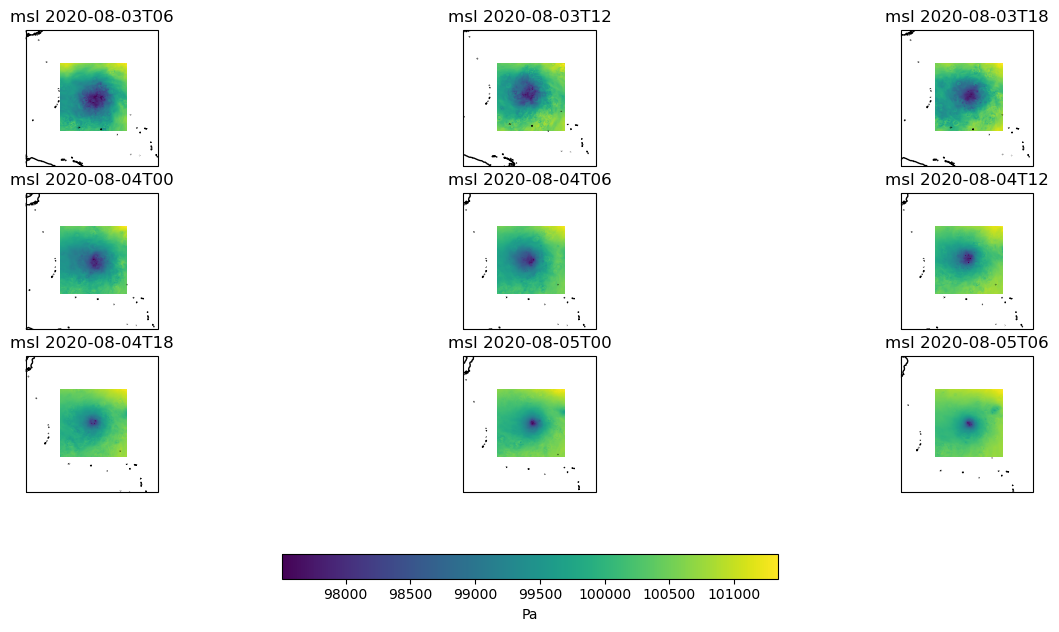

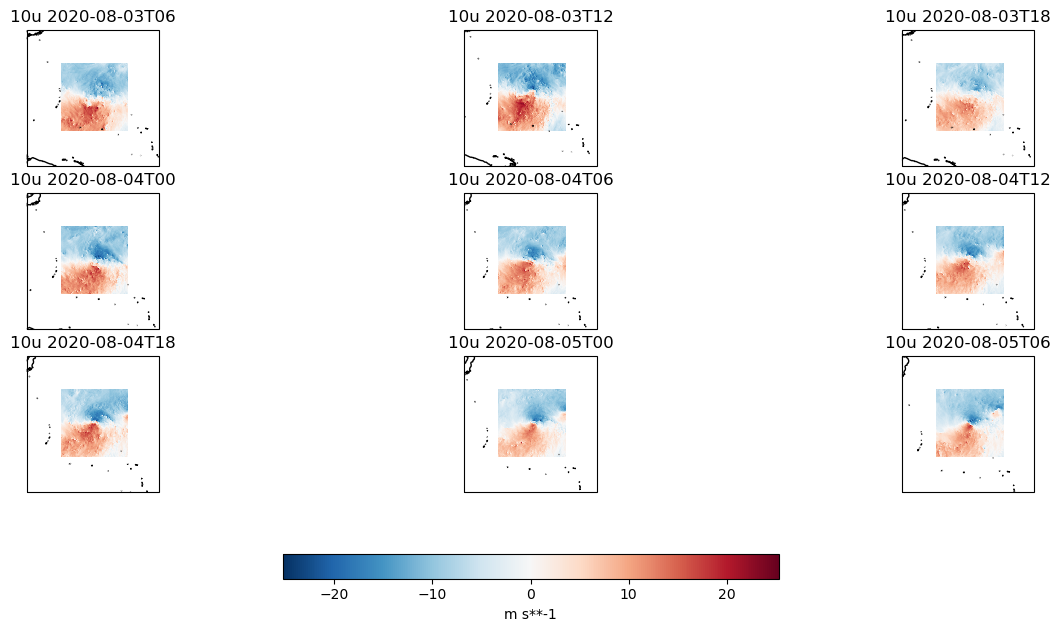

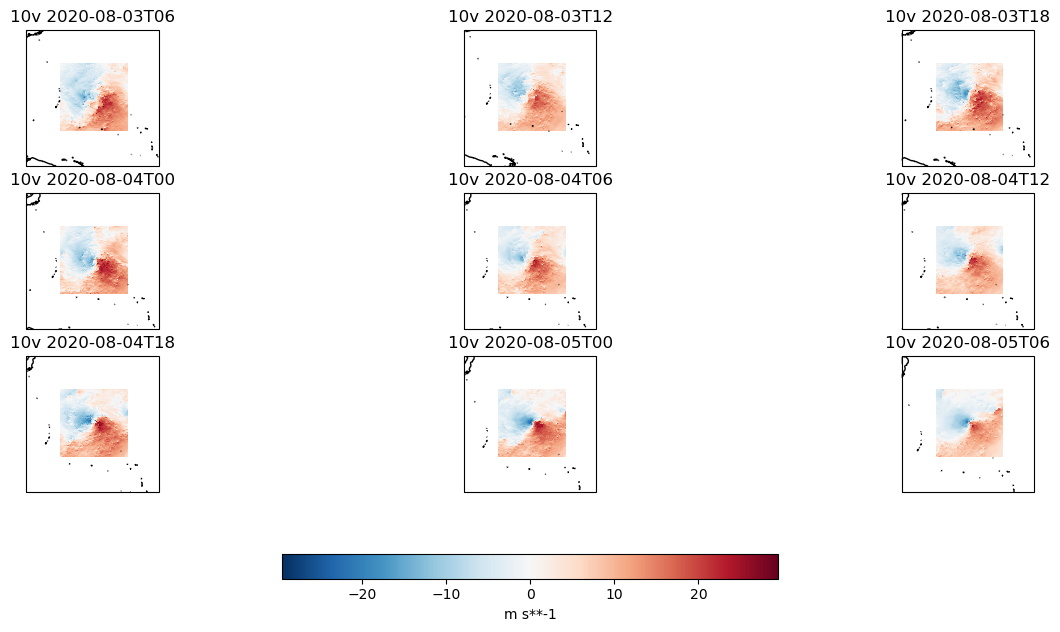

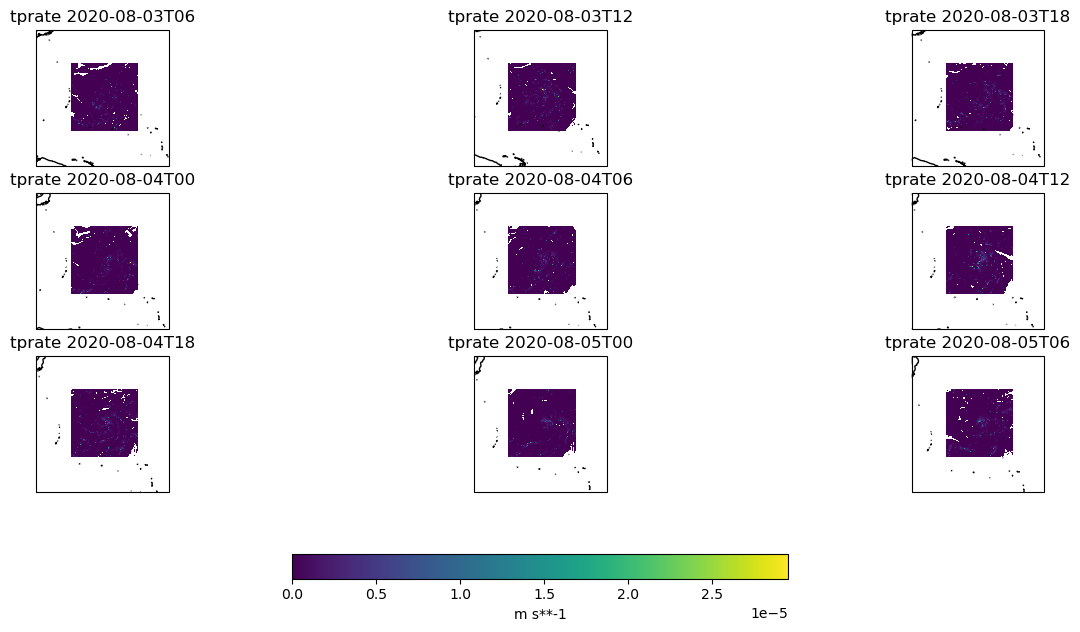

In [5]:
import xarray as xr
import os
from plotting_TCs import multi_plot

# variables to be plotted are in che config file

for var in tdict['varlist']: 

    tracks_nc_file = os.path.join(tdict['paths']['fulldir'], f"tempest_tracks_{var}_20200801-20200810.nc")
    tracks_nc_file = xr.open_dataset(tracks_nc_file)[var]
    multi_plot(tracks_nc_file)

Plot TCs track for every period chosen (according to n_days_freq assigned to StitcchNodes)

2020-08-01 00:00:00
Getting trajectories from TempestExtremes file...
Running getTrajectories on '/scratch/b/b382216/tmpdir_tco2559-ng5/tempest_track_20200801-20200810.txt' with unstruc set to '0'
nVars set to 10 and headerDelimStr set to 'start'
Found 10 columns
Found 2 trajectories
... done reading data


/work/bb1153/b382216/mambaforge/envs/TCs/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/work/bb1153/b382216/mambaforge/envs/TCs/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:475: UserWarning: The .ylabels_left attribute is deprecated. Please use .left_labels to toggle visibility instead.
  warnings.warn('The .ylabels_left attribute is deprecated. Please '


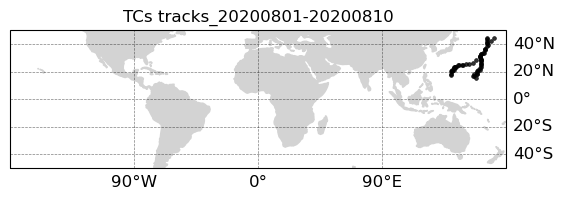

2020-08-11 00:00:00
Getting trajectories from TempestExtremes file...
Running getTrajectories on '/scratch/b/b382216/tmpdir_tco2559-ng5/tempest_track_20200811-20200820.txt' with unstruc set to '0'
nVars set to 10 and headerDelimStr set to 'start'
Found 10 columns
Found 3 trajectories
... done reading data


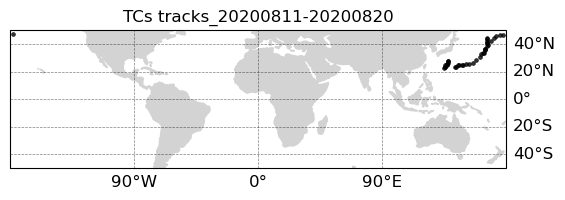

2020-08-21 00:00:00
Getting trajectories from TempestExtremes file...
Running getTrajectories on '/scratch/b/b382216/tmpdir_tco2559-ng5/tempest_track_20200821-20200830.txt' with unstruc set to '0'
nVars set to 10 and headerDelimStr set to 'start'
Found 10 columns
Found 3 trajectories
... done reading data


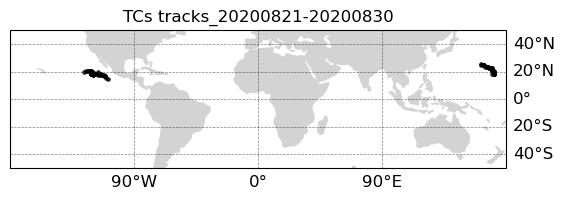

2020-08-31 00:00:00
Getting trajectories from TempestExtremes file...
Running getTrajectories on '/scratch/b/b382216/tmpdir_tco2559-ng5/tempest_track_20200831-20200909.txt' with unstruc set to '0'
nVars set to 10 and headerDelimStr set to 'start'
Found 10 columns
Found 4 trajectories
... done reading data


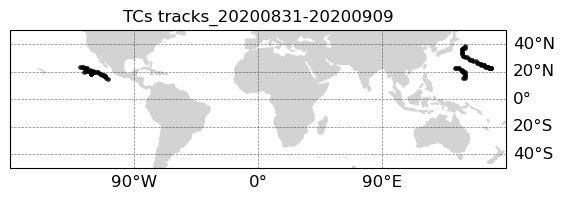

2020-09-10 00:00:00
Getting trajectories from TempestExtremes file...
Running getTrajectories on '/scratch/b/b382216/tmpdir_tco2559-ng5/tempest_track_20200910-20200919.txt' with unstruc set to '0'
nVars set to 10 and headerDelimStr set to 'start'


FileNotFoundError: [Errno 2] No such file or directory: '/scratch/b/b382216/tmpdir_tco2559-ng5/tempest_track_20200910-20200919.txt'

<Figure size 640x480 with 0 Axes>

In [5]:
import xarray as xr
import os
from plotting_TCs import plot_trajectories

# loop on each time stamp in dates
for block in pd.date_range(start=tdict['time']['startdate'], end=tdict['time']['enddate'], freq=str(10)+'D'):
    print (block)
    dates = pd.date_range(start=block, periods=10)
    track_file = os.path.join(tdict['paths']['tmpdir'], f"tempest_track_{dates[0].strftime('%Y%m%d')}-{dates[-1].strftime('%Y%m%d')}.txt")
    plot_trajectories(track_file, tdict['paths']['plotdir'], block, dates)